# Xgboost to predict player ratings

Random Forest Regressor earlier had given some promising score but it can be further improved by gradient-boosted trees. In this notebook I will be using XGBoost to try get a better result.

XGBoost creates a weak tree and then "boosts" the subsequent trees to reduce the residual errors. It tries to capture and address any patterns in the erros until they appear to be random.

In [1]:
import pandas as pd
import numpy as np

import os
import sys

path = os.getcwd().replace('\\notebooks', '')
script_path = os.path.join(path, 'utils')

sys.path.append(script_path)

from preprocess import *

In [6]:
train_data = get_data('processed_data', 'full_train.csv')
train_data.head()

,game_id,nickname,score,bot_nickname,bot_score,bot_rating,rating,first,time_control_name,game_end_reason,...,bot_std,turn_number,Player_Exchanged,Player_Passed,Player_Six_Rule,Player_Challenged,Bot_Exchanged,Bot_Passed,Bot_Six_Rule,Bot_Challenged
0,1,stevy,429,BetterBot,335,1637,1500,1,regular,STANDARD,...,16.457794,27,0,0,0,0,0,0,0,0
1,3,davidavid,440,BetterBot,318,2071,1811,1,regular,STANDARD,...,18.058310,27,0,0,0,0,1,0,0,0
2,4,Inandoutworker,119,BetterBot,478,1936,1473,1,regular,RESIGNED,...,20.945053,29,1,0,0,0,0,0,0,0
3,5,stevy,325,STEEBot,427,1844,1500,1,regular,STANDARD,...,20.346522,31,1,0,0,0,0,0,0,0
4,6,HivinD,378,STEEBot,427,2143,2029,0,regular,STANDARD,...,23.572039,25,0,0,0,0,1,0,0,0


## Splitting data into train and test set

In [7]:
X_train, X_test, y_train, y_test = split_data(train_data)

def drop_columns(df):
  df_new = df.drop(columns=['game_id', 'nickname'])
  return df_new

train_x = drop_columns(X_train)
test_x = drop_columns(X_test)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

Preprocess = ColumnTransformer([
    ('oneHotEncoding', OneHotEncoder(), [1,5,6,8,11])
], remainder= 'passthrough')

training_data = Preprocess.fit_transform(train_x)

testing_x = Preprocess.transform(test_x)

Now that we are down with the preprocessing, we can implement the XGBoost model

In [30]:
import xgboost as xgb

In [30]:
xgb_class = xgb.XGBRegressor(random_state = 123,objective='reg:squarederror', eval_metric = 'rmse')

xgb_class.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)>

In [31]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(i) for i in np.linspace(100, 2000, num = 15)]
max_depth = [int(i) for i in np.linspace(5,30, num = 5)]
learning_rate = [0.01, 0.1, 0.3]
subsample = [0.5, 0.1, 0.2]



param_grid = {'n_estimators':n_estimators,
'max_depth':max_depth,
'subsample': subsample,
'learning_rate': learning_rate,
'colsample_bytree': np.arange(0.4, 1.0, 0.1),
'colsample_bylevel': np.arange(0.4, 1.0, 0.1)
}

random_xgb = RandomizedSearchCV(estimator= xgb_class, param_distributions=param_grid, scoring='neg_mean_squared_error',n_iter = 50)

In [32]:
random_xgb.fit(training_data, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=Non...
                                          predictor=None, random_state=123, ...),
                   n_iter=50,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [5, 11, 17, 23, 30],
                                        'n_estimators': [100, 235, 371, 507,
                                                         642, 778, 914, 1050,
                                                         1185, 1321, 1457, 1592,
                                                         1728, 1864, 2000],
                                        'subsample': [0.5, 0.1, 0.2]},
                   scoring='neg_mean_squared_error')

In [33]:
random_xgb.best_params_

{'subsample': 0.5,
 'n_estimators': 914,
 'max_depth': 11,
 'learning_rate': 0.01,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 0.8999999999999999}

In [34]:
best_model = random_xgb.best_estimator_

In [35]:
evaluate_model(testing_x,y_test, best_model)

8.470280708931432

In [36]:
test_data = get_data('processed_data', 'full_test.csv')

test = drop_columns(test_data)

testing_df = Preprocess.transform(test)

# Make Submission

In [37]:
save_submission('xgb_prediction_2', best_model, testing_df)

,game_id,rating
0,2,1995.942017
1,7,1982.928467
2,11,1644.058105
3,14,1984.356323
4,27,2062.488770
...,...,...
22358,72760,2000.962524
22359,72761,1546.426636
22360,72762,1607.843140
22361,72768,2030.825195


# Save Model for later

In [39]:
save_model_or_pipeline(best_model, 'XGBoost', 'models')

## Loading the model

In [48]:
xgboost_model = load_model_or_pipeline('XGBoost', 'models')

Now that the model is loaded, we can first evaluate it to make sure it was laoded properly

In [49]:
evaluate_model(testing_x,y_test, xgboost_model)

8.470280708931432

model seem to have loaded properly, now its time to calculate feature importance

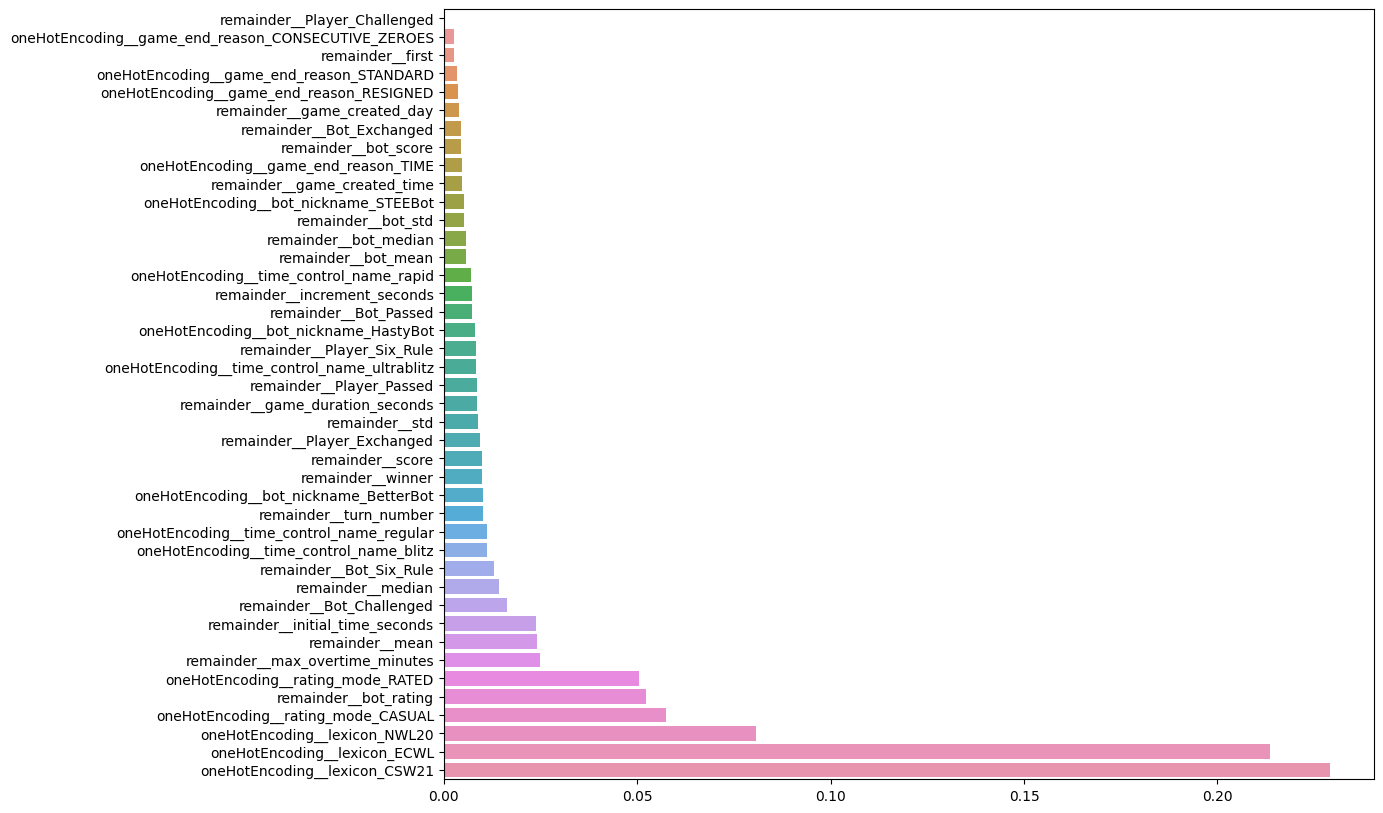

In [29]:
fig, ax = plt.subplots(ncols=1, figsize=(12,10))

idx = xgboost_model.feature_importances_.argsort()
y = Preprocess.get_feature_names_out()[idx]

sns.barplot(y= y, x = xgboost_model.feature_importances_[idx], ax = ax)

plt.show()


We can also use the built in plot from xgboost

In [33]:
from xgboost import plot_importance
from matplotlib import pyplot

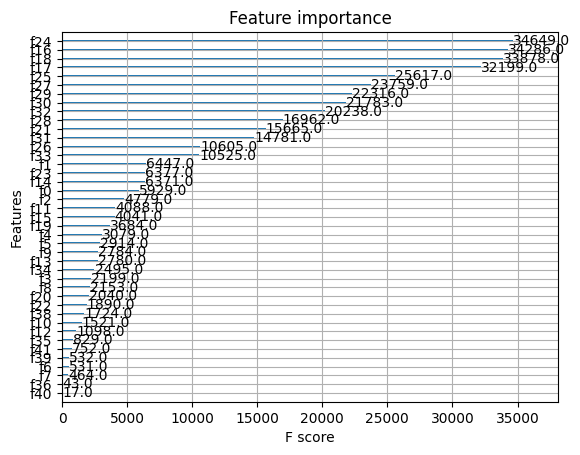

In [34]:
plot_importance(xgboost_model)
pyplot.show()